In [1]:
from i2.tests.util import mk_func_from_params
from i2 import Sig

f = mk_func_from_params('2244')
assert str(Sig(f)) == '(*a20, *a21, **a42, **a43)'
assert f(0,1,2,3, x=4, y=5) == "a20=(0, 1, 2, 3), a21=(), a42={}, a43={'x': 4, 'y': 5}"

ValueError: You can't have several variadic keywords: ('a20', 'a21')

In [1]:
from meshed import DAG, FuncNode


In [6]:
def f(a, **kwargs): # also test  the *args ! pb if f and g have kwargs (check "mk_all_pk" , or nice_kinds in i2)
    print(kwargs)
    return a

In [7]:
f_node = FuncNode(func=f)
d = DAG([f_node])  # breakpoint
    # args = ['a'=1]
    # kwargs = {'x'=3}

    # d(*args, **kwargs
scope = d.sig.kwargs_from_args_and_kwargs((), {"a": 1, "x": 3})

In [8]:
scope

{'a': 1, 'kwargs': {'x': 3}}

In [12]:
from i2 import kwargs_from_args_and_kwargs

ImportError: cannot import name 'kwargs_from_args_and_kwargs' from 'i2' (/Users/sylvain/Desktop/dev/otosense/i2/i2/__init__.py)

In [17]:
from i2 import Sig
>>> def foo(w, /, x: float, y="YY", *, z: str = "ZZ"):
        pass     
>>> sig = Sig(foo)
>>> assert (sig.kwargs_from_args_and_kwargs((11, 22, "you"), dict(z="zoo"))
         == sig.kwargs_from_args_and_kwargs((11, 22), dict(y="you", z="zoo"))
         == {"w": 11, "x": 22, "y": "you", "z": "zoo"}
     )
        

In [197]:
from i2 import Sig
def foo(w, /, x: float, y="YY", *, z: str = "ZZ", **rest):
        pass     
sig = Sig(foo)
#assert (sig.kwargs_from_args_and_kwargs((11, 22, "you"), dict(z="zoo", other="stuff"))
#         == sig.kwargs_from_args_and_kwargs((11, 22), dict(y="you", z="zoo"))
#         == {"w": 11, "x": 22, "y": "you", "z": "zoo"}
#     )

In [198]:
sig.kwargs_from_args_and_kwargs((11, 22, "you"), dict(z="zoo", other="stuff"))

{'w': 11, 'x': 22, 'y': 'you', 'z': 'zoo', 'rest': {'other': 'stuff'}}

In [199]:
from i2.signatures import VK

def maybe_first(items):
    return items[0] if items else None
    
def name_of_var_kw_argument(sig):
    var_kw_list = [param.name for param in sig.params if param.kind == VK] 
    result = maybe_first(var_kw_list)
    return result

def map_action_on_cond(kvs, cond, expand):
    for k,v in kvs:
        if cond(k):
            yield from expand(v)
        else:
            yield k,v

def flatten_if_var_kw(kvs, var_kw_name):
    cond = lambda k:k==var_kw_name
    expand = lambda k:k.items()

    return map_action_on_cond(kvs, cond, expand)

In [208]:
def kwargs_from_args_and_kwargs(
        self,
        args,
        kwargs,
        *,
        apply_defaults=False,
        allow_partial=False,
        allow_excess=False,
        ignore_kind=False,
        post_process = False
    ):
        """Extracts a dict of input argument values for target signature, from args
        and kwargs.

        When you need to manage how the arguments of a function are specified,
        you need to take care of
        multiple cases depending on whether they were specified as positional arguments
        (`args`) or keyword arguments (`kwargs`).

        The `kwargs_from_args_and_kwargs` (and it's sorta-inverse inverse,
        `args_and_kwargs_from_kwargs`)
        are there to help you manage this.

        If you could rely on the the fact that only `kwargs` were given it would
        reduce the complexity of your code.
        This is why we have the `all_pk_signature` function in `signatures.py`.

        We also need to have a means to make a `kwargs` only from the actual `(*args,
        **kwargs)` used at runtime.
        We have `Signature.bind` (and `bind_partial`) for that.

        But these methods will fail if there is extra stuff in the `kwargs`.
        Yet sometimes we'd like to have a `dict` that services several functions that
        will extract their needs from it.

        That's where  `Sig.extract_kwargs(*args, **kwargs)` is needed.
        :param args: The args the function will be called with.
        :param kwargs: The kwargs the function will be called with.
        :param apply_defaults: (bool) Whether to apply signature defaults to the
        non-specified argument names
        :param allow_partial: (bool) True iff you want to allow partial signature
        fulfillment.
        :param allow_excess: (bool) Set to True iff you want to allow extra kwargs
        items to be ignored.
        :param ignore_kind: (bool) Set to True iff you want to ignore the position and
        keyword only kinds,
            in order to be able to accept args and kwargs in such a way that there can
            be cross-over
            (args that are supposed to be keyword only, and kwargs that are supposed
            to be positional only)
        :return: An {argname: argval, ...} dict

        See also the sorta-inverse of this function: args_and_kwargs_from_kwargs

        >>> def foo(w, /, x: float, y="YY", *, z: str = "ZZ"):
        ...     ...
        >>> sig = Sig(foo)
        >>> assert (
        ...     sig.kwargs_from_args_and_kwargs((11, 22, "you"), dict(z="zoo"))
        ...     == sig.kwargs_from_args_and_kwargs((11, 22), dict(y="you", z="zoo"))
        ...     == {"w": 11, "x": 22, "y": "you", "z": "zoo"}
        ... )

        By default, `apply_defaults=False`, which will lead to only get those
        arguments you input.

        >>> sig.kwargs_from_args_and_kwargs(args=(11,), kwargs={"x": 22})
        {'w': 11, 'x': 22}

        But if you specify `apply_defaults=True` non-specified non-require arguments
        will be returned with their defaults:

        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(11,), kwargs={"x": 22}, apply_defaults=True
        ... )
        {'w': 11, 'x': 22, 'y': 'YY', 'z': 'ZZ'}

        By default, `ignore_excess=False`, so specifying kwargs that are not in the
        signature will lead to an exception.

        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(11,), kwargs={"x": 22, "not_in_sig": -1}
        ... )
        Traceback (most recent call last):
            ...
        TypeError: Got unexpected keyword arguments: not_in_sig

        Specifying `allow_excess=True` will ignore such excess fields of kwargs.
        This is useful when you want to source several functions from a same dict.

        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(11,), kwargs={"x": 22, "not_in_sig": -1}, allow_excess=True
        ... )
        {'w': 11, 'x': 22}

        On the other side of `ignore_excess` you have `allow_partial` that will allow
        you, if
        set to `True`, to underspecify the params of a function (in view of being
        completed later).

        >>> sig.kwargs_from_args_and_kwargs(args=(), kwargs={"x": 22})
        Traceback (most recent call last):
          ...
        TypeError: missing a required argument: 'w'

        But if you specify `allow_partial=True`...

        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(), kwargs={"x": 22}, allow_partial=True
        ... )
        {'x': 22}

        That's a lot of control (eight combinations total), but not everything is
        controllable here:
        Position only and keyword only kinds need to be respected:

        >>> sig.kwargs_from_args_and_kwargs(args=(1, 2, 3, 4), kwargs={})
        Traceback (most recent call last):
          ...
        TypeError: too many positional arguments
        >>> sig.kwargs_from_args_and_kwargs(args=(), kwargs=dict(w=1, x=2, y=3, z=4))
        Traceback (most recent call last):
          ...
        TypeError: 'w' parameter is positional only, but was passed as a keyword

        But if you want to ignore the kind of parameter, just say so:

        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(1, 2, 3, 4), kwargs={}, ignore_kind=True
        ... )
        {'w': 1, 'x': 2, 'y': 3, 'z': 4}
        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(), kwargs=dict(w=1, x=2, y=3, z=4), ignore_kind=True
        ... )
        {'w': 1, 'x': 2, 'y': 3, 'z': 4}
        """
        no_var_kw = not self.has_var_keyword
        #no_var_kw = True


        if ignore_kind:
            sig = self.normalize_kind(
                # except_kinds=frozenset()
            )
        else:
            sig = self

        # no_var_kw = not sig.has_var_keyword TODOD check this
        if no_var_kw:  # has no var keyword kinds
            sig_relevant_kwargs = {
                name: kwargs[name] for name in sig if name in kwargs
            }  # take only what you need
        else:
            sig_relevant_kwargs = kwargs  # take all the kwargs
        binder = sig.bind_partial if allow_partial else sig.bind
        if not self.has_var_positional and allow_excess:
            max_allowed_num_of_posisional_args = sum(
                k <= PK for k in self.kinds.values()
            )
            args = args[:max_allowed_num_of_posisional_args]

        b = binder(*args, **sig_relevant_kwargs)
        if apply_defaults:
            b.apply_defaults()

        if no_var_kw and not allow_excess:  # don't ignore excess kwargs
            excess = kwargs.keys() - b.arguments
            if excess:
                excess_str = ', '.join(excess)
                raise TypeError(f'Got unexpected keyword arguments: {excess_str}')
        
        
        if post_process:
            var_kw_name = name_of_var_kw_argument(self)

            kvs = b.arguments.items()

            flattened_kvs = flatten_if_var_kw(kvs, var_kw_name)
            result = dict(flattened_kvs)

        else:
            result = b.arguments
        return result
        

In [209]:
sig, sig.has_var_keyword

(<Sig (w, /, x: float, y='YY', *, z: str = 'ZZ', **rest)>, True)

In [211]:
res = kwargs_from_args_and_kwargs(sig, (11, 22, "you"), dict(z="zoo", other="stuff"), post_process=True)
res

{'w': 11, 'x': 22, 'y': 'you', 'z': 'zoo', 'other': 'stuff'}

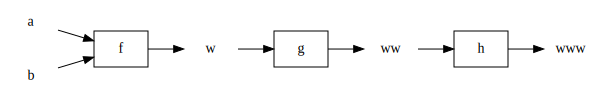

In [1]:
from meshed import code_to_dag

@code_to_dag
def dag():
    w = f(a, b)
    ww = g(c=w)
    www = h(x=ww)

dag.dot_digraph('rankdir="LR"')

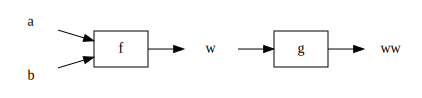

In [14]:
dag[['w']:'ww'].dot_digraph('rankdir="LR"')

In [8]:
def getitem2(self, item):
        """Get a sub-dag from a specification of (var or fun) input and output nodes.
        ``dag[input_nodes:output_nodes]`` is the sub-dag made of intersection of all
        descendants of ``input_nodes``
        (inclusive) and ancestors of ``output_nodes`` (inclusive), where additionally,
        when a func node is contained, it takes with it the input and output nodes
        it needs.
        >>> def f(a): ...
        >>> def g(f): ...
        >>> def h(g): ...
        >>> def i(h): ...
        >>> dag = DAG([f, g, h, i])
        See what this dag looks like (it's a simple pipeline):
        >>> dag = DAG([f, g, h, i])
        >>> print(dag.synopsis_string())
        a -> f_ -> f
        f -> g_ -> g
        g -> h_ -> h
        h -> i_ -> i
        Get a subdag from ``g_`` (indicates the function here) to the end of ``dag``
        >>> subdag = dag['g_':]
        >>> print(subdag.synopsis_string())
        f -> g_ -> g
        g -> h_ -> h
        h -> i_ -> i
        From the beginning to ``h_``
        >>> print(dag[:'h_'].synopsis_string())
        a -> f_ -> f
        f -> g_ -> g
        g -> h_ -> h
        From ``g_`` to ``h_`` (both inclusive)
        >>> print(dag['g_':'h_'].synopsis_string())
        f -> g_ -> g
        g -> h_ -> h
        Above we used function (node names) to specify what we wanted, but we can also
        use names of input/output var-nodes. Do note the difference though.
        The nodes you specify to get a sub-dag are INCLUSIVE, but when you
        specify function nodes, you also get the input and output nodes of these
        functions.
        The ``dag['g_', 'h_']`` give us a sub-dag starting at ``f`` (the input node),
        but when we ask ``dag['g', 'h_']`` instead, ``g`` being the output node of
        function node ``g_``, we only get ``g -> h_ -> h``:
        >>> print(dag['g':'h'].synopsis_string())
        g -> h_ -> h
        If we wanted to include ``f`` we'd have to specify it:
        >>> print(dag['f':'h'].synopsis_string())
        f -> g_ -> g
        g -> h_ -> h
        Those were for simple pipelines, but let's now look at a more complex dag.
        We'll let the following examples self-comment:
        >>> def f(u, v): ...
        >>> def g(f): ...
        >>> def h(f, w): ...
        >>> def i(g, h): ...
        >>> def j(h, x): ...
        >>> def k(i): ...
        >>> def l(i, j): ...
        >>> dag = DAG([f, g, h, i, j, k, l])
        >>> print(dag.synopsis_string())
        u,v -> f_ -> f
        f,w -> h_ -> h
        h,x -> j_ -> j
        f -> g_ -> g
        g,h -> i_ -> i
        i,j -> l_ -> l
        i -> k_ -> k
        A little util to get consistent prints:
        >>> def print_sorted_synopsis(dag):
        ...     t = sorted(dag.synopsis_string().split('\\n'))
        ...     print('\\n'.join(t))
        >>> print_sorted_synopsis(dag[['u', 'f']:'h'])
        f,w -> h_ -> h
        u,v -> f_ -> f
        >>> print_sorted_synopsis(dag['u':'h'])
        f,w -> h_ -> h
        u,v -> f_ -> f
        >>> print_sorted_synopsis(dag[['u', 'f']:['h', 'g']])
        f -> g_ -> g
        f,w -> h_ -> h
        u,v -> f_ -> f
        >>> print_sorted_synopsis(dag[['x', 'g']:'k'])
        g,h -> i_ -> i
        i -> k_ -> k
        >>> print_sorted_synopsis(dag[['x', 'g']:['l', 'k']])
        g,h -> i_ -> i
        h,x -> j_ -> j
        i -> k_ -> k
        i,j -> l_ -> l
        >>>
        """
        return self._getitem(item)

def _getitem(self, item):
        ins, outs = self.process_item(item)
        print(ins)
        _descendants = set(
            filter(FuncNode.has_as_instance, set(ins) | descendants(self.graph, ins))
        )
        _ancestors = set(
            filter(FuncNode.has_as_instance, set(outs) | ancestors(self.graph, outs))
        )
        subgraph_nodes = _descendants.intersection(_ancestors)
        # TODO: When clone ready, use to do `constructor = type(self)` instead of DAG
        # constructor = type(self)  # instead of DAG
        initial_nodes = self.func_nodes
        ordered_subgraph_nodes = order_subset_from_list(initial_nodes, subgraph_nodes)

        return DAG(
            func_nodes=ordered_subgraph_nodes,
            cache_last_scope=self.cache_last_scope,
            parameter_merge=self.parameter_merge,
        )

In [12]:
type(dag).__getitem__ = getitem2

In [13]:
dag['w':'ww']

DAG(func_nodes=[FuncNode(a,b -> f -> w), FuncNode(c=w -> g -> ww)], name=None)

In [20]:
from meshed import DAG

In [23]:
        >>> def f(a): ...
        >>> def g(f): ...
        >>> def h(g): ...
        >>> def i(h): ...
        >>> dag = DAG([f, g, h, i])
        #See what this dag looks like (it's a simple pipeline):
        >>> dag = DAG([f, g, h, i])
        #>>> print(dag.synopsis_string())
        #a -> f_ -> f
        #f -> g_ -> g
        #g -> h_ -> h
        #h -> i_ -> i
        #Get a subdag from ``g_`` (indicates the function here) to the end of ``dag``
        >>> subdag = dag['g_':]
        #>>> print(subdag.synopsis_string())
        #f -> g_ -> g
        #g -> h_ -> h
        #h -> i_ -> i
        #From the beginning to ``h_``
        #>>> print(dag[:'h_'].synopsis_string())
        #a -> f_ -> f
        #f -> g_ -> g
        #g -> h_ -> h
        #From ``g_`` to ``h_`` (both inclusive)
        #>>> print(dag['g_':'h_'].synopsis_string())
        >>> print(dag['g':'h_'].synopsis_string())

f -> g_ -> g
g -> h_ -> h


# Check the Subdags

In [25]:
from scrap_dag import DAG as MDAG

In [ ]:
#def w = f(a, b)
#    ww = g(c=w)
#    www = h(x=ww)

# get_node_matching

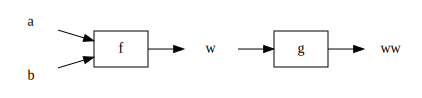

In [2]:
from meshed import code_to_dag

@code_to_dag
def dag():
    w = f(a, b)
    ww = g(c=w)
    #www = h(x=ww)

dag.dot_digraph('rankdir="LR"')

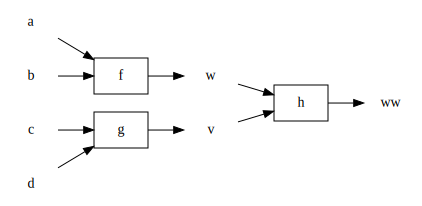

In [27]:
from meshed import DAG

@code_to_dag
def dag():
    w = f(a, b)
    v = g(c,d)
    ww = h(w,v)


dag.dot_digraph('rankdir="LR"')

In [85]:
dag.get_node_matching('ww')

'ww'

In [86]:
dag._func_node_for['ww']

FuncNode(w,v -> h -> ww)

In [88]:
dag.process_item(slice('w','ww'))

(['w'], ['ww'])

In [75]:
from typing import Callable, Iterable
from meshed.util import (
    lambda_name,
    ValidationError,)

def process_item_mod(self, item):
        assert isinstance(item, slice), f'must be a slice, was: {item}'

        input_names, outs = item.start, item.stop

        empty_slice = slice(None)

        def ensure_variable_list(obj):
            if obj is None:
                return self.var_nodes
            if isinstance(obj, str):
                obj = obj.split()
            if isinstance(obj, (str, Callable)):
                # TODO: See if we can use _func_node_for instead
                print('isinstance(obj, (str, Callable)?')
                return [self._func_node_for(obj)]
                #return [self.get_node_matching(obj)]
            elif isinstance(obj, Iterable):
                # TODO: See if we can use _func_node_for instead
                #print('isinstance(obj, Iterable))?')

                return list(map(self.get_node_matching, obj))
                #func = lambda k:self._func_node_for[k]
                #return list(map(func, obj))

            else:
                raise ValidationError(f'Unrecognized variables specification: {obj}')

        # assert len(item) == 2, f"Only items of size 1 or 2 are supported"
        input_names, outs = map(ensure_variable_list, [input_names, outs])
        return input_names, outs

Careful: what happens if we use an output name? 

In [76]:
dag.get_node_matching('w'), dag._func_node_for['w']

('w', FuncNode(a,b -> f -> w))

In [77]:
process_item_mod(dag,slice('w',None))

(['w'], ['d', 'c', 'v', 'b', 'a', 'w', 'ww'])

In [79]:
# shouldn't we return all leaves only (and not also the roots)?
# Using get_node_matching
#(['w'], ['d', 'c', 'v', 'b', 'a', 'w', 'ww'])
# Using _func_node_for
#assert str(process_item_mod(dag,slice('w',None))) == "([FuncNode(a,b -> f -> w)], ['d', 'c', 'v', 'b', 'a', 'w', 'ww'])"

In [80]:
subdag = dag['w':]

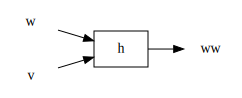

In [81]:
subdag.dot_digraph('rankdir="LR"')

In [ ]:
    def get_node_matching(self, pattern):
        if isinstance(pattern, str):
            if pattern in self.var_nodes:
                return pattern
            return self.func_node_for_name(pattern)
        elif isinstance(pattern, Callable):
            return self.func_node_for_func(pattern)
        raise NotFound(f'No matching node: {pattern}')

    def func_node_for_name(self, name):
        return _find_unique_element(
            name, self.func_nodes, lambda name, fn: name == fn.name
        )

    def func_node_for_func(self, func):
        return _find_unique_element(
            func, self.func_nodes, lambda func, fn: func == fn.func
        )

    # TODO: Reflect: Should we include functions as keys here? Makes existence of the
    #  item depend on unicity of the function in the DAG, therefore dynamic, so instable?
    @cached_property
    def _func_node_for(self):
        """A dictionary mapping identifiers and functions to their FuncNode instances
        in the DAG. The keys of this dictionary will include:

        - identifiers (names) of the ``FuncNode`` instances
        - ``out`` of ``FuncNode`` instances
        - The ``.func`` of the ``FuncNode`` instances if it's unique.

        >>> def foo(x): return x + 1
        >>> def bar(x): return x * 2
        >>> dag = DAG([
        ...     FuncNode(foo, out='foo_output'),
        ...     FuncNode(bar, name='B', out='b', bind={'x': 'foo_output'}),
        ... ])

        A ``FuncNode`` instance is indexed by both its identifier (``.name``) as well as
        the identifier of it's output (``.out``):

        >>> dag._func_node_for['foo_output']
        FuncNode(x -> foo -> foo_output)
        >>> dag._func_node_for['foo']
        FuncNode(x -> foo -> foo_output)
        >>> dag._func_node_for['b']
        FuncNode(x=foo_output -> B -> b)
        >>> dag._func_node_for['B']
        FuncNode(x=foo_output -> B -> b)

        If the function is hashable (most are) and unique within the ``DAG``, you
        can also find the ``FuncNode`` via the ``.func`` it's wrapping:

        >>> dag._func_node_for[foo]
        FuncNode(x -> foo -> foo_output)
        >>> dag._func_node_for[bar]
        FuncNode(x=foo_output -> B -> b)

        A word of warning though: The function index is provided as a convenience, but
        using identifiers is preferable since referencing via the function object
        depends on the other functions of the DAG, so could change if we add nodes.
        
        """
        d = dict()
        for func_node in self.func_nodes:
            d[func_node.out] = func_node
            d[func_node.name] = func_node

            try:
                if func_node.func not in d:
                    # if .func not in d already, remember the link
                    d[func_node.func] = func_node
                else:
                    # if .func was already in there, mark it for removal
                    # (but leaving the key present so that we know about the duplication)
                    d[func_node.func] = None
            except TypeError:
                # ignore (and don't include func) if not hashable
                pass

        # remove the items marked for removal and return
        return {k: v for k, v in d.items() if v is not None}